In [1]:
import sys
sys.path.append("../")

In [2]:
from glob import glob
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    CropForegroundd,
    Spacingd
)
import os.path
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np


In [3]:
supervised_dir = "/mnt/HDD2/flare2022/datasets/FLARE2022/Training/FLARE22_LabeledCase50"
def get_paths(path: str):
    paths = glob(os.path.join(supervised_dir, path, "*.nii.gz"))
    paths.sort()
    return paths

In [4]:
image_paths = get_paths("images")
label_paths = get_paths("labels")

data_dicts = tuple(
    {"image": img, "label": lab} for img, lab in zip(image_paths, label_paths)
)


In [5]:
keys = ("image", "label")
transforms = Compose(
    (
        LoadImaged(reader="NibabelReader", keys=keys),
        EnsureChannelFirstd(keys=keys),
        Orientationd(keys, axcodes="RAI"),
        CropForegroundd(keys=keys, source_key="label"),
        Spacingd(keys="image", pixdim=(1, 1, 1)),
    )
)

In [6]:
num_workers = 4
dataset = Dataset(data_dicts, transforms)
dl = DataLoader(
    dataset,
    batch_size=1,
    num_workers=num_workers,
)

In [7]:
spatial_size = 3
image_sizes = np.empty((len(dl), spatial_size), dtype=np.uint16)

for i, batch in enumerate(tqdm(dl)):
    image_sizes[i] = batch["image"].shape[-spatial_size:]

100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


In [8]:
labels = ("Frontal (X) Axis", "Sagittal (Y) Axis", "Longitudinal (Z) Axis")

![CT Scan Axes](ct_scan_axes.png)

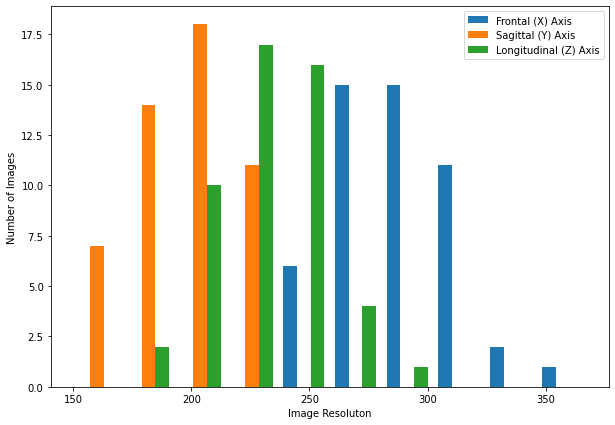

In [9]:
plt.figure(figsize=(10, 7))
plt.hist(image_sizes, bins="auto", label=labels)
plt.xlabel("Image Resoluton")
plt.ylabel("Number of Images")
plt.legend();

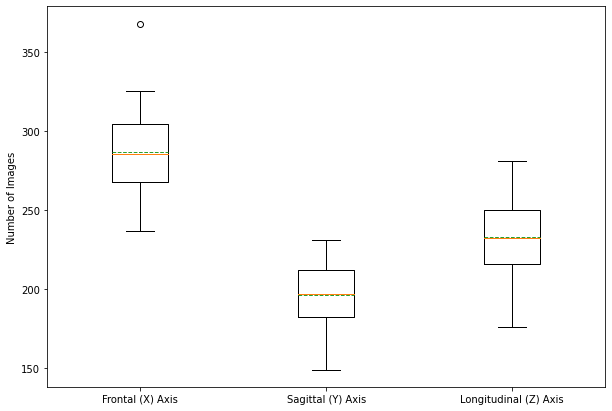

In [10]:
plt.figure(figsize=(10, 7))
plt.boxplot(
    image_sizes,
    showmeans=True,
    meanline=True,
    labels=labels,
)
plt.ylabel("Image Resolution");


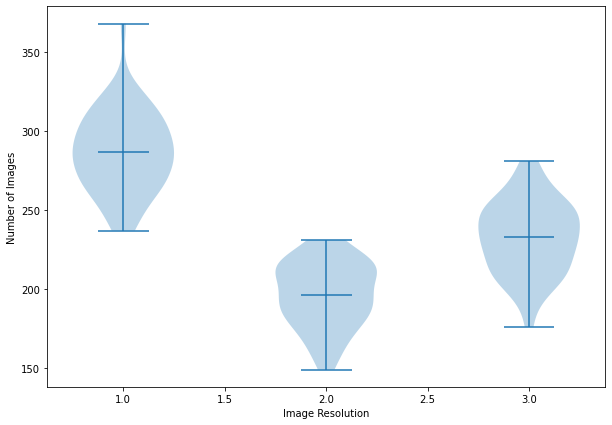

In [11]:
plt.figure(figsize=(10, 7))
plt.violinplot(image_sizes, showmeans=True)
plt.xlabel("Image Axes")
plt.ylabel("Image Resolution");

In [12]:
image_volumes = image_sizes.prod(axis=1)

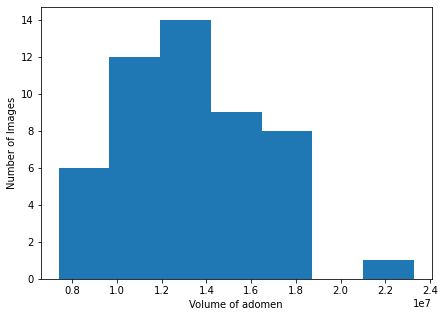

In [13]:
plt.figure(figsize=(7, 5))
plt.hist(image_volumes, bins="auto")
plt.xlabel("Volume of adomen in mm^3")
plt.ylabel("Number of Images");

Images with outlier volumes

In [14]:
outlier_indices = np.where(image_volumes > 1.8e7)
outlier_indices

(array([37, 44]),)

In [15]:
image_sizes[outlier_indices]

array([[306, 218, 271],
       [368, 225, 281]], dtype=uint16)

Image with maximum volume

In [16]:
max_index = image_volumes.argmax()
max_index

44

In [17]:
image_sizes[max_index]

array([368, 225, 281], dtype=uint16)

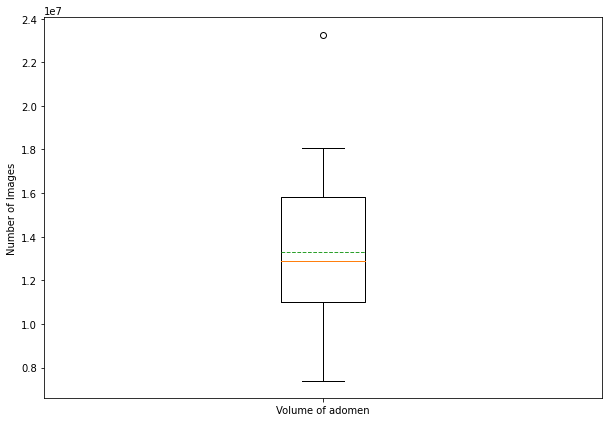

In [18]:
plt.figure(figsize=(10, 7))
plt.boxplot(image_volumes, showmeans=True, meanline=True, labels=("Volume of adomen",))
plt.ylabel("Size in mm^3");

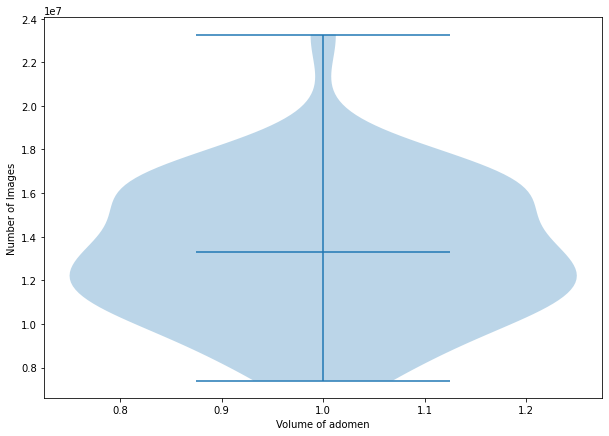

In [19]:
plt.figure(figsize=(10, 7))
plt.violinplot(image_volumes, showmeans=True)
plt.xlabel("Adbomen Volume")
plt.ylabel("Size in mm^3");

Calculate max size in each dimension

In [20]:
max_shape = image_sizes.max(axis=0)
max_shape

array([368, 231, 281], dtype=uint16)

In [21]:
max_shape.prod()

23887248

In [22]:
image_volumes[max_index]

23266800

In [23]:
image_sizes.min(axis=0)

array([237, 149, 176], dtype=uint16)

Proportion of each axis

In [26]:
image_size_prop = (image_sizes.T / image_sizes.sum(axis=1)).T

In [30]:
assert (
    image_size_prop.sum() == image_size_prop.shape[0]
), "The proportion is not properly normalized"


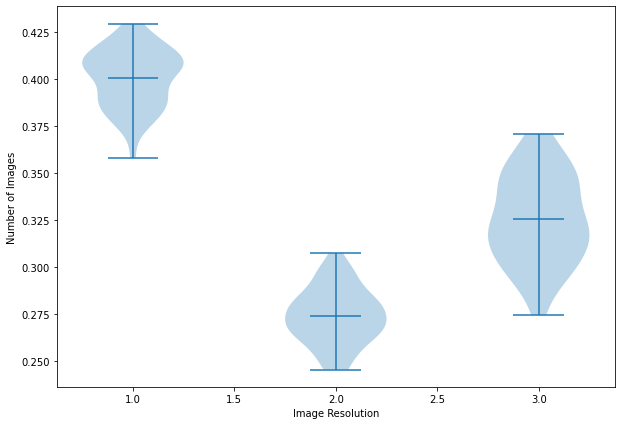

In [32]:
plt.figure(figsize=(10, 7))
plt.violinplot(image_size_prop, showmeans=True)
plt.ylabel("Image Proportion")
plt.xlabel("CT Axes");